<a href="https://colab.research.google.com/github/josesg998/competencia_properati/blob/main/TP_Individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Lectura de datos

In [54]:
DIR = "/content/drive/MyDrive/Data Mining Properati/"

df_train = pd.read_feather(DIR + 'properati_entrenamiento.ftr').set_index('id')
df_test = pd.read_feather(DIR + "properati_a_predecir.ftr").set_index('id')

In [ ]:
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_train.head()

# df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
#df_test.head()

# df_train = pd.read_csv('bases/properati_entrenamiento.csv',index_col='id')
# df_test = pd.read_csv('bases/properati_a_predecir.csv',index_col='id')
# df_test.head()

# df_train.reset_index(drop=False).to_feather('bases/properati_entrenamiento.ftr')
# df_test.reset_index(drop=False).to_feather('bases/properati_a_predecir.ftr')

In [4]:
#df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')
#df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train.head(3)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2019-07-07,2019-07-10,2019-07-07,NaN,NaN,Argentina,Buenos Aires Interior,Urquiza,Urquiza,...,NaN,NaN,NaN,3800.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (SLC-SI1-560) Alquiler de Cochera en CA...,Cochera,Alquiler
2,Propiedad,2019-07-07,9999-12-31,2019-07-07,-64.184812,-31.421307,Argentina,Córdoba,Córdoba,None,...,NaN,12.0,12.0,16000.0,USD,Mensual,Cochera venta,VENDO COCHERA- EXCELENTE UBICACIÓN! Calle Buen...,Cochera,Venta
3,Propiedad,2019-07-07,2019-07-09,2019-07-07,-57.965880,-34.902568,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,NaN,12.0,NaN,16000.0,USD,None,Cochera cubierta con portón automatizado en ve...,Cochera Cubierta en venta ubicada en calle 7 e...,Cochera,Venta


In [8]:
df = pd.concat((df_train,df_test),axis=0)
df.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2019-07-07,2019-07-10,2019-07-07,NaN,NaN,Argentina,Buenos Aires Interior,Urquiza,Urquiza,...,NaN,NaN,NaN,3800.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (SLC-SI1-560) Alquiler de Cochera en CA...,Cochera,Alquiler
2,Propiedad,2019-07-07,9999-12-31,2019-07-07,-64.184812,-31.421307,Argentina,Córdoba,Córdoba,None,...,NaN,12.0,12.0,16000.0,USD,Mensual,Cochera venta,VENDO COCHERA- EXCELENTE UBICACIÓN! Calle Buen...,Cochera,Venta
3,Propiedad,2019-07-07,2019-07-09,2019-07-07,-57.965880,-34.902568,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,NaN,12.0,NaN,16000.0,USD,None,Cochera cubierta con portón automatizado en ve...,Cochera Cubierta en venta ubicada en calle 7 e...,Cochera,Venta
4,Propiedad,2019-07-07,2019-11-11,2019-07-07,-58.556622,-34.547333,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Ballester,...,NaN,NaN,NaN,2100.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (ALE-ALE-8596) Alquiler de Cochera en V...,Cochera,Alquiler
5,Propiedad,2019-07-07,9999-12-31,2019-07-07,-58.486344,-34.663334,Argentina,Capital Federal,Mataderos,None,...,NaN,NaN,NaN,75000.0,USD,Mensual,Venta de PH de 3 ambientes CABA,CODIGO: 2417-Larraya 2700 CABA ubicado en: Lar...,PH,Venta


<Axes: ylabel='id'>

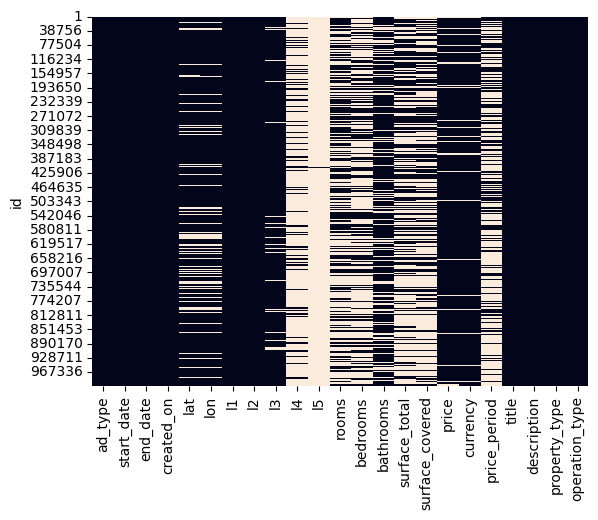

In [9]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

In [ ]:
df_test.shape

(6000, 24)

# Entendimiento (magia parte 1 -- AID)

In [ ]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ad_type,994000,1,Propiedad,994000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,994000,346,2020-03-21,13171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,994000,450,9999-12-31,190441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_on,994000,346,2020-03-21,13171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,840826.0,NaN,NaN,NaN,-59.264786,2.704534,-180.0,-58.754528,-58.44429,-58.069144,-35.045025
lon,841760.0,NaN,NaN,NaN,-34.793299,3.062879,-54.842464,-34.920924,-34.610161,-34.460719,85.051129
l1,994000,4,Argentina,975230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l2,994000,42,Capital Federal,251843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l3,936714,1262,Mar del Plata,158074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l4,225232,976,Nordelta,17310,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 1 to 757314
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ad_type          1000000 non-null  object 
 1   start_date       1000000 non-null  object 
 2   end_date         808371 non-null   object 
 3   created_on       1000000 non-null  object 
 4   lat              846370 non-null   float64
 5   lon              847305 non-null   float64
 6   l1               1000000 non-null  object 
 7   l2               1000000 non-null  object 
 8   l3               942503 non-null   object 
 9   l4               225691 non-null   object 
 10  l5               4711 non-null     object 
 11  l6               0 non-null        float64
 12  rooms            510328 non-null   float64
 13  bedrooms         396315 non-null   float64
 14  bathrooms        780531 non-null   float64
 15  surface_total    455880 non-null   float64
 16  surface_covered  44

In [ ]:
df.agg({'start_date':['min','max'],
        'end_date':['min','max'],
        'created_on':['min','max']})

,start_date,end_date,created_on
min,2019-07-04,2019-07-04,2019-07-04
max,2020-07-27,9999-12-31,2020-07-27


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [ ]:
# df_test.loc[df_test['end_date']=='9999-12-31','end_date'] = np.nan
# df_train.loc[df_train['end_date']=='9999-12-31','end_date'] = np.nan

# df_train[['end_date','start_date','created_on']] = df_train[['end_date','start_date','created_on']].applymap(lambda x:pd.to_datetime(x))
# df_test[['end_date','start_date','created_on']] = df_test[['end_date','start_date','created_on']].applymap(lambda x:pd.to_datetime(x))

In [55]:
df_train.drop(columns='l6',inplace=True)
df_test.drop(columns='l6',inplace=True)

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

In [56]:
cols_a_imputar = ['lat', 'lon']
#imp = KNNImputer(n_neighbors=3, weights="distance", add_indicator=True) # tiene add_indicator
imp = IterativeImputer(max_iter=10,random_state=42)

df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

In [57]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [17]:
df_train.isnull().sum()

ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                  57286
l4                 768768
l5                 989289
rooms                   0
bedrooms                0
bathrooms               0
surface_total           0
surface_covered         0
price               44381
currency            47251
price_period       625976
title                  28
description            22
property_type           0
operation_type          0
dtype: int64

In [19]:
df_train.isnull().sum()

ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                  54756
l4                 731572
l5                 944998
rooms                   0
bedrooms                0
bathrooms               0
surface_total           0
surface_covered         0
price                   0
currency             2870
price_period       612322
title                  28
description            20
property_type           0
operation_type          0
dtype: int64

In [39]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [24]:
df_train.columns

Index(['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price'],
      dtype='object')

In [30]:
df_train.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2019-07-07,2019-07-10,2019-07-07,-59.265256,-34.793299,Argentina,Buenos Aires Interior,Urquiza,Urquiza,...,1.712497,392.914615,-386.607690,3800.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (SLC-SI1-560) Alquiler de Cochera en CA...,Cochera,Alquiler
2,Propiedad,2019-07-07,9999-12-31,2019-07-07,-64.184812,-31.421307,Argentina,Córdoba,Córdoba,None,...,1.148317,12.000000,12.000000,16000.0,USD,Mensual,Cochera venta,VENDO COCHERA- EXCELENTE UBICACIÓN! Calle Buen...,Cochera,Venta
3,Propiedad,2019-07-07,2019-07-09,2019-07-07,-57.965880,-34.902568,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,1.631689,12.000000,-1355.190177,16000.0,USD,None,Cochera cubierta con portón automatizado en ve...,Cochera Cubierta en venta ubicada en calle 7 e...,Cochera,Venta
4,Propiedad,2019-07-07,2019-11-11,2019-07-07,-58.556622,-34.547333,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Ballester,...,1.712497,392.914615,-386.607690,2100.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (ALE-ALE-8596) Alquiler de Cochera en V...,Cochera,Alquiler
5,Propiedad,2019-07-07,9999-12-31,2019-07-07,-58.486344,-34.663334,Argentina,Capital Federal,Mataderos,None,...,1.712497,392.914615,-386.607690,75000.0,USD,Mensual,Venta de PH de 3 ambientes CABA,CODIGO: 2417-Larraya 2700 CABA ubicado en: Lar...,PH,Venta


In [31]:
df_train.l2.unique()

array(['Buenos Aires Interior', 'Córdoba', 'Bs.As. G.B.A. Zona Sur',
       'Bs.As. G.B.A. Zona Norte', 'Capital Federal', 'Santa Fe',
       'Tucumán', 'Buenos Aires Costa Atlántica', 'Maldonado', 'San Luis',
       'Neuquén', 'Bs.As. G.B.A. Zona Oeste', 'Entre Ríos', 'Montevideo',
       'Mendoza', 'Misiones', 'Río Negro', 'Tierra Del Fuego',
       'Pennsylvania', 'Chubut', 'Corrientes', 'Salta', 'La Rioja',
       'La Pampa', 'Chaco', 'San Juan', 'Rocha', 'Jujuy', 'Maryland',
       'Canelones', 'Santa Catarina', 'Colonia', 'Florida', 'Santa Cruz',
       'Michigan', 'Miami', 'Santiago Del Estero', 'Rio de Janeiro',
       'Formosa', 'Catamarca', 'Rio Grande do Norte', 'São Paulo'],
      dtype=object)

Mirar outliers de precios (muy altos y los que valen 1)

Imputar nulos de cantidad de baños

Buscar datos externos (precio por m2 antes de la pandemia)

Agregar precio por m2

Ver distancia a lugar especiales

Buscar cuasi duplicados

Encontrar dptos que tengan el precio o una columna con info

La predicción es en dólares, ver qué hacer con otras monedas

Chequear distribución de test y train

Hacer modelos para distintas ciudades (chequear balance al partir entre train y test)

Usar k-means con lat y lon. También se puede agregar la distancia al centroide

In [60]:
lugares = ['Bs.As. G.B.A. Zona Sur','Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']
df_train = df_train[df_train.l2.isin(lugares)]
df_test = df_test[df_test.l2.isin(lugares)]

In [61]:
# Datos para probar
df_train = df_train[~df_train.price.isnull()]
df_train = df_train.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [62]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=3598169397526.3154 score_test=595456815284.5374
fold=1, score_train=3477705145572.3774 score_test=1141458476657.1934
fold=2, score_train=3557128296548.257 score_test=530649212845.9384
fold=3, score_train=2812406547266.828 score_test=29544758706119.0
fold=4, score_train=3479287113765.643 score_test=1027432060318.5809
fold=5, score_train=3444150208007.769 score_test=800176667338.4716
fold=6, score_train=1191283635043.357 score_test=23695983706750.57
fold=7, score_train=3592917340193.1655 score_test=596884232675.7614
fold=8, score_train=3384828259327.272 score_test=9624794721792.44
fold=9, score_train=3523881883155.439 score_test=994705447411.6946
Train scores mean=3206175782640.642, std=743792381845.7395
Test scores mean=6855230004719.418, std=10863128227611.248


# Predicción para kaggle


In [63]:
## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
df_test['price'].to_csv('solucion.csv', index=True)

In [64]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False)

,column,feature_importance
1,lon,0.592976
4,bathrooms,0.139155
0,lat,0.097409
5,surface_total,0.090443
6,surface_covered,0.036000
3,bedrooms,0.029633
2,rooms,0.014382
